<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab6.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 6: Sequence-to-sequence models

### Description:
For this lab, you will code up the [char-rnn model of Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). This is a recurrent neural network that is trained probabilistically on sequences of characters, and that can then be used to sample new sequences that are like the original.

This lab will help you develop several new skills, as well as understand some best practices needed for building large models. In addition, we'll be able to create networks that generate neat text!

### Deliverable:
- Fill in the code for the RNN (using PyTorch's built-in GRU).
- Fill in the training loop
- Fill in the evaluation loop. In this loop, rather than using a validation set, you will sample text from the RNN.
- Implement your own GRU cell.
- Train your RNN on a new domain of text (Star Wars, political speeches, etc. - have fun!)

### Grading Standards:
- 20% Implementation the RNN
- 20% Implementation training loop
- 20% Implementation of evaluation loop
- 20% Implementation of your own GRU cell
- 20% Training of your RNN on a domain of your choice

### Tips:
- Read through all the helper functions, run them, and make sure you understand what they are doing
- At each stage, ask yourself: What should the dimensions of this tensor be? Should its data type be float or int? (int is called `long` in PyTorch)
- Don't apply a softmax inside the RNN if you are using an nn.CrossEntropyLoss (this module already applies a softmax to its input).

### Example Output:
An example of my final samples are shown below (more detail in the
final section of this writeup), after 150 passes through the data.
Please generate about 15 samples for each dataset.

<code>
And ifte thin forgision forward thene over up to a fear not your
And freitions, which is great God. Behold these are the loss sub
And ache with the Lord hath bloes, which was done to the holy Gr
And appeicis arm vinimonahites strong in name, to doth piseling 
And miniquithers these words, he commanded order not; neither sa
And min for many would happine even to the earth, to said unto m
And mie first be traditions? Behold, you, because it was a sound
And from tike ended the Lamanites had administered, and I say bi
</code>


---

## Part 0: Readings, data loading, and high level training

---

There is a tutorial here that will help build out scaffolding code, and get an understanding of using sequences in pytorch.

* Read the following

> * [Pytorch sequence-to-sequence tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) (Take note that you will not be implementing the encoder part of this tutorial.)
* [Understanding LSTM Networks](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)






In [ ]:
! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

import unidecode
import string
import random
import re
 
import pdb
 
all_characters = string.printable
n_characters = len(all_characters)
file = unidecode.unidecode(open('./text_files/lotr.txt').read())
file_len = len(file)
print('file_len =', file_len)

In [2]:
chunk_len = 200
 
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
print(random_chunk())

se is not clear to me, and I fear to 
say too much.' 

'I am deeply grateful,' said Frodo; 'but I wish you would tell me 
plainly what the Black Riders are. If I take your advice I may not see 
Gandalf


In [ ]:
import torch
# Turn string into list of longs
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
      tensor[c] = all_characters.index(string[c])
  return tensor

print(char_tensor('abcDEF'))

---

## Part 4: Creating your own GRU cell 

**(Come back to this later - its defined here so that the GRU will be defined before it is used)**

---

The cell that you used in Part 1 was a pre-defined Pytorch layer. Now, write your own GRU class using the same parameters as the built-in Pytorch class does.

Please try not to look at the GRU cell definition. The answer is right there in the code, and in theory, you could just cut-and-paste it. This bit is on your honor!

**TODO:**
* Create a custom GRU cell

**DONE:**



In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

    # Using nn.ModueList to store n layers of the 6 linear weight matrices
    self.w_ir = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    self.w_hr = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    self.w_iz = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    self.w_hz = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    self.w_in = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    self.w_hn = nn.ModuleList([nn.Linear(input_size, hidden_size) for i in range(num_layers)])
    
  def forward(self, inputs, hidden):
    # Initializing hiddens to store the output of each layer
    hiddens = torch.empty(size=(self.num_layers, 1, self.hidden_size), dtype=torch.float, device = 'cuda') 
    for i in range(self.num_layers):
      r_t = self.sigmoid(self.w_ir[i](inputs) + self.w_hr[i](hidden[i]))
      z_t = self.sigmoid(self.w_iz[i](inputs) + self.w_hz[i](hidden[i]))
      n_t = self.tanh(self.w_in[i](inputs) + torch.mul(r_t, self.w_hn[i](hidden[i])))
      h_t = torch.mul((1 - z_t), n_t) + torch.mul(z_t, hidden[i])
      inputs = hiddens[i] = h_t

    return h_t, hiddens

---

##  Part 1: Building a sequence to sequence model

---

Great! We have the data in a useable form. We can switch out which text file we are reading from, and trying to simulate.

We now want to build out an RNN model, in this section, we will use all built in Pytorch pieces when building our RNN class.


**TODO:**
* Create an RNN class that extends from nn.Module.

**DONE:**



In [36]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers
    
    # self.gru = nn.GRU(input_size, hidden_size, n_layers) # nn module
    self.gru = GRU(hidden_size, hidden_size, n_layers) # custom module: expects input as [1,1,hidden_size] rather than [1,1,n_characters] due to embedding and GRU structure

    self.linear_layer = nn.Linear(hidden_size, output_size)
    # self.embedding = nn.Embedding(input_size, output_size)  # nn module
    self.embedding = nn.Embedding(input_size, hidden_size) # custom module: making embedding [1,1,hidden_size] rather than [1,1,n_characters]

  def forward(self, input_char, hidden):
    out_decoded = self.embedding(input_char).view(1,1,-1)
    out_decoded, hidden = self.gru(out_decoded, hidden)
    out_decoded = self.linear_layer(out_decoded[-1])
    return out_decoded, hidden

  def init_hidden(self):
    return torch.zeros(self.n_layers, 1, self.hidden_size)

In [6]:
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

---

## Part 2: Sample text and Training information

---

We now want to be able to train our network, and sample text after training.

This function outlines how training a sequence style network goes. 

**TODO:**
* Fill in the pieces.

**DONE:**




In [7]:
def longToTensor(input, classes=100):
    input_char = input.long()
    input_char = F.one_hot(input_char, num_classes=classes)
    input = torch.unsqueeze(input_char, 0)
    input = torch.unsqueeze(input, 0)  
    input = input.float()
    return input

def train(inp, target):
  decoder_optimizer.zero_grad()
  hidden_state = decoder.init_hidden()
  hidden_state = hidden_state.cuda(non_blocking=True)
  loss = 0

  for x, y_truth in zip(inp, target):
    x, y_truth = x.cuda(non_blocking=True), y_truth.cuda(non_blocking=True)
    
    out_decoded, hidden_state = decoder(x, hidden_state) 
    y_truth = longToTensor(y_truth)[-1]
    loss += criterion(out_decoded, y_truth)

  loss.backward()
  decoder_optimizer.step()
  return loss.item()

---

## Part 3: Sample text and Training information

---

You can at this time, if you choose, also write out your train loop boilerplate that samples random sequences and trains your RNN. This will be helpful to have working before writing your own GRU class.

If you are finished training, or during training, and you want to sample from the network you may consider using the following function. If your RNN model is instantiated as `decoder`then this will probabilistically sample a sequence of length `predict_len`

**TODO:**
* Fill out the evaluate function to generate text frome a primed string

**DONE:**



In [8]:
def sample_outputs(output, temperature):
    return torch.multinomial(torch.exp(output / temperature), 1)

def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  hidden_state = decoder.init_hidden()
  hidden_state = hidden_state.cuda(non_blocking=True)

  if type(prime_str) == str:
    prime_str = char_tensor(prime_str)
    prime_str = prime_str.cuda(non_blocking=True)

  output_sequence = []
  input_string = prime_str


  for x in input_string:
    output_sequence.append(x.item())
    out_decoded, hidden_state = decoder(x, hidden_state)
  output = sample_outputs(out_decoded, temperature)

  for _ in range(predict_len):
    input_tensor = output
    output_sequence.append(input_tensor.item())
    out_decoded, hidden_state = decoder(input_tensor, hidden_state) 
    output = sample_outputs(out_decoded, temperature)

  output_string = ''
  for idx in output_sequence:
    char = all_characters[idx]
    output_string += char
   
  return output_string

---

## Part 4: (Create a GRU cell, requirements above)

---



---

## Part 5: Run it and generate some text!

---


**TODO:** 
* Create some cool output

**DONE:**




Assuming everything has gone well, you should be able to run the main function in the scaffold code, using either your custom GRU cell or the built in layer, and see output something like this. I trained on the “lotr.txt” dataset, using chunk_length=200, hidden_size=100 for 2000 epochs. These are the results, along with the prime string:

---

 G:
 
 Gandalf was decrond. 
'All have lord you. Forward the road at least walk this is stuff, and 
went to the long grey housel-winding and kindled side was a sleep pleasuring, I do long 
row hrough. In  

 lo:
 
 lost death it. 
'The last of the gatherings and take you,' said Aragorn, shining out of the Gate. 
'Yes, as you there were remembaused to seen their pass, when? What 
said here, such seven an the sear 

 lo:
 
 low, and frod to keepn 
Came of their most. But here priced doubtless to an Sam up is 
masters; he left hor as they are looked. And he could now the long to stout in the right fro horseless of 
the like 

 I:
 
 I had been the 
in his eyes with the perushed to lest, if then only the ring and the legended 
of the less of the long they which as the 
enders of Orcovered and smood, and the p 

 I:
 
 I they were not the lord of the hoomes. 
Home already well from the Elves. And he sat strength, and we 
housed out of the good of the days to the mountains from his perith. 

'Yess! Where though as if  

 Th:
 
 There yarden 
you would guard the hoor might. Far and then may was 
croties, too began to see the drumbred many line 
and was then hoard walk and they heart, and the chair of the 
Ents of way, might was 

 G:
 
 Gandalf 
been lat of less the round of the stump; both and seemed to the trees and perished they 
lay are speered the less; and the wind the steep and have to she 
precious. There was in the oonly went 

 wh:
 
 which went out of the door. 
Hull the King and of the The days of his brodo 
stumbler of the windard was a thing there, then it been shining langing 
to him poor land. They hands; though they seemed ou 

 ra:
 
 rather,' have all the least deather 
down of the truven beginning to the house of sunk. 
'Nark shorts of the Eyes of the Gate your great nothing as Eret. 
'I wander trust horn, and there were not, it  

 I:
 
 I can have no mind 
together! Where don't may had one may little blung 
terrible to tales. And turn and Gandalf shall be not to as only the Cattring 
not stopped great the out them forms. On they she lo 

---


In [13]:
import time
n_epochs = 5000
print_every = 200
plot_every = 10
hidden_size = 200
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder = decoder.cuda()

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [14]:
for epoch in range(1, n_epochs + 1):
  loss_ = train(*random_training_set())
  loss_avg += loss_

  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[72.31673288345337 (200 4%) 472.1450]
Whe horh os ise I Bo
we Ann wowar Nore fars the yelt ale hard tin 
wit fimd and erod 
the there ard th 

[146.94324707984924 (400 8%) 401.2514]
Whan and wis and to 
here sountin the raigher those to gwast the crey ip 
pepstwerle farning puver 
so 

[215.79877257347107 (600 12%) 377.6049]
Where and in though ain the Carbop there vorased whet to -netherght has stent and 
of this to han pead 

[283.9594340324402 (800 16%) 372.9977]
Where 
soun of Mere the 
the his to but his that were he neather, thove to have that ligh the ancoure- 

[353.0054786205292 (1000 20%) 338.7914]
Whe four me and came of the 
parn at non the 
of momed 
was, 
evill reant of the wall is the Fring the 

[420.35806345939636 (1200 24%) 312.0645]
Whe hat 
what I came compet was the 

can the open sied hope that it into the most the doonse the pame 

[491.232280254364 (1400 28%) 305.9774]
Whey with things was bon will for he waters, and could be 
the was durning a 
the limust the b

Text(0, 0.5, 'Loss')

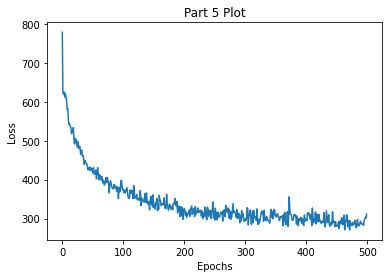

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

plt.title("Part 5 Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [23]:
import random
for i in range(10):
  start_strings = [" Th", " wh", " he", " I ", " ca", " G", " lo", " ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
  print(evaluate(start_strings[start], 200), '\n')

 I 
 I have I can't your worning! There we reckon more. Then plain 
loud what had way. Hills do near it a shadow or line 
as must be halls mean. But there will le seemed 
a ring, falling crossed, and they we 

 I 
 I fire in not country in the open to Elf. 

'More-had do not can with lend.' 

'Boromir! Horn filled, Sam, so that is trees! I would's the bowest line of the 
each in the air. The long cane room hands a 

 wh
 whipped should had far 
eyes of Gondor thing; and come we came tried to see the 
horn to hear I cries. He set dared sound of the fire clear. But me what has 
cluugodness no well, I which the horright we 

 I 
 I can 
trin-way fallen in, since he little. In the pellow as it side of a gate or and desire, out of the horn-since grew wind himself and made up not he 
reatured up in the prink of this man. But you 
n 

 Th
 The Ents now good with a little 
he came of grey more it at no command. But who singing his feet hand. I could not see, you not such in the 








horses

---

## Part 6: Generate output on a different dataset

---

**TODO:**

* Choose a textual dataset. Here are some [text datasets](https://www.kaggle.com/datasets?tags=14104-text+data%2C13205-text+mining) from Kaggle 

* Generate some decent looking results and evaluate your model's performance (say what it did well / not so well)

**DONE:**



In [16]:
# Editing helper functions
def char_tensor_df(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    tensor[c] = all_characters.index(string[c])
  return tensor

def random_training_set_df(txt, file_len):    
  chunk = random_chunk_df(txt, file_len)
  inp = char_tensor_df(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

def random_chunk_df(txt, file_len):
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return txt[start_index:end_index]

In [24]:
# Importing data and converting it into correct structure
import pandas as pd
path = '/content/drive/MyDrive/nytimes front page.csv'
df_nyt = pd.read_csv(path, lineterminator='\n', parse_dates=True)

tweets_col = list(df_nyt['content'])
nyt_file = ' '.join(str(e) for e in tweets_col)
nyt_file_len = len(nyt_file)

In [25]:
import time
n_epochs = 5000
print_every = 200
plot_every = 10
hidden_size = 200
n_layers = 3
lr = 0.001
 
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder = decoder.cuda()

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
 
start = time.time()
all_losses = []
loss_avg = 0

In [26]:
for epoch in range(1, n_epochs + 1):
  try:
    inp, target = random_training_set_df(nyt_file, nyt_file_len)
  except:
    loop = True
    while loop:
      try:
        inp, target = random_training_set_df(nyt_file, nyt_file_len)
        loop = False
      except:
        pass
  loss_ = train(inp, target)
  loss_avg += loss_
      
  if epoch % print_every == 0:
      print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss_))
      print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0:
      all_losses.append(loss_avg / plot_every)
      loss_avg = 0

[73.79147529602051 (200 4%) 514.3355]
Wh
arteg ror ant bur pan to Reserallorer. onle rorect sant, to Rerhe thre maed t creolonil pasetesite  

[142.3275294303894 (400 8%) 464.8100]
Wh ere the the Utered peevere of candinsting the Widen wan hes an diountend dewele thansing ins and th 

[211.00077366828918 (600 12%) 393.7355]
Wherdes fieds an. Erut, p-onth the startan at binimes bave that the dach the reciises of that tan cout 

[280.3670358657837 (800 16%) 377.6238]
Wh a greas sto be unthoon and in Sestilitian than $0000 offication month or the ijstucts. M. Abroul a  

[352.94293427467346 (1000 20%) 359.9921]
Wh alrigh a bound in thow wishwonsion, fround to a recaoks on prekill and, Dussed are. Bethe Werthat p 

[422.0792520046234 (1200 24%) 360.8398]
Who servives, whout a jola, are connuritatannar albook doons more cheach in the chin a vicrotion Congr 

[490.48428201675415 (1400 28%) 418.9056]
Whack and the percent or the and Mr. Gasan leaders and the shopersands. Even a down fade beca

Text(0, 0.5, 'Loss')

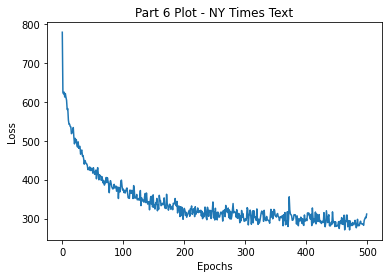

In [34]:
plt.figure()
plt.plot(all_losses)

plt.title("Part 6 Plot - NY Times Text")
plt.xlabel("Epochs")
plt.ylabel("Loss")

In [29]:
import random
for i in range(10):
  start_strings = ["Tr", "wh", "he", "I ", "ca", "G", "lo", "ra"]
  start = random.randint(0,len(start_strings)-1)
  print(start_strings[start])
  print(evaluate(start_strings[start], 200), '\n')

I 
I seassells and he could be beline court rounds who was sturning shot said. The China, in the Christiah the police around they according to ramping with astory called particular states. The Europe she d 

G
Gero, to even that his admoring the same of the one of a memie to varmethips for knew the network more allies relear even the fataliage. He was the jobs throok called but the issue, when the dusticals  

ra
rablin case a growth lave after the investigations in 2012, the police sellow consused Mr. Trump and investigation influenced he had also the buses not early conferent cline and a second of the manufere 

G
Grame secretory of finally by largely opening of the denor and she had corned by their personnents. It not of his single denesday. The difted accounts and he coaling a months into Mind Part Berson Pake 

wh
when health more to much off a month sanction of somaliar, where the announce Chinancy in 2018 and Corport Planning at 2086 percents from the state suspect of a racemine

My model peformed fairly well on the NY Times articles dataset. I was really impressed by the validation senstences and the final generation of 10 blocks of text from the previous code block. For the most part, the sentences have a coherent structure and the words are mostly correct. However, this dataset did seem more difficult for the model to generate great text, compared to part 5. One of the reasons for this is likely due to the fact that this file had a length of over 12 million, whereas the data set (file) provided at the beginning of the lab had a few hundred thousand. Due to this big difference in size, this dataset was likely much harder to train on, so I may have gotten better results if I ran more epochs or perhaps created a file that was a smaller subset of the nytimes data set, and then sampled from that subset. 